# Time series train/test splitting

We can't use standard k-fold CV on time series, but there're two common approaches (except for a simple split on data sorted by time) - fixed window validation and expanding window validation.

- the more data we have the better, so expanding window seems like a better choice 
- if we use expanding windows, our training folds will be different in size and it would be harder to evaluate models' performance, because they were trained on different amounts of data
- data is seasonal so it's important to capture at least a whole year (all the seasons) of data for training

We can modify expanding windows so they have an offset and don't start from the first date (historically) in our dataset, this way training folds won't differ in size as much and will resemble fixed window validation, but still provide more data.

Although offset is possible, it still makes sense to start the training window since the very start, 'cause we have less than 3 whole years of data, and it's not that much

A simple *validation class* that would split data according to the scheme above would be:

In [7]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

In [8]:
class ValidationClass:
    
    def __init__(self):
        self._train_start = None
        self._val_start = None
        self._val_end = None
    
    def split_data(self, data, train_start : date, val_start: date):
        if train_start > val_start:
            raise ValueError('Validation fold can''t be before training fold')
        if (val_start - train_start).days < 365:
            raise ValueError('Train start and validation start must be at least a year apart')
            
        self._train_start = pd.Timestamp(train_start)
        self._val_start = pd.Timestamp(val_start)
        self._val_end = pd.Timestamp(val_start + timedelta(days=30))
   
        if 'date' not in data.columns:
            raise ValueError('Dataset doesnt have ''date'' feature')
    
        return data[(data['date'] >= self._train_start) & (data['date'] <  self._val_start)], data[(data['date'] >=  self._val_start) & (data['date'] <  self._val_end)] 

### Example

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
sales = pd.read_csv('../data/interim/sales_train_etl.csv', parse_dates=['date'])

In [11]:
def get_dynamics(data):
    return data.groupby(['date'], as_index=False).agg({'item_cnt_day' : 'sum'}).rename({'item_cnt_day' : 'items_sold'}, axis=1)

In [12]:
vc = ValidationClass()

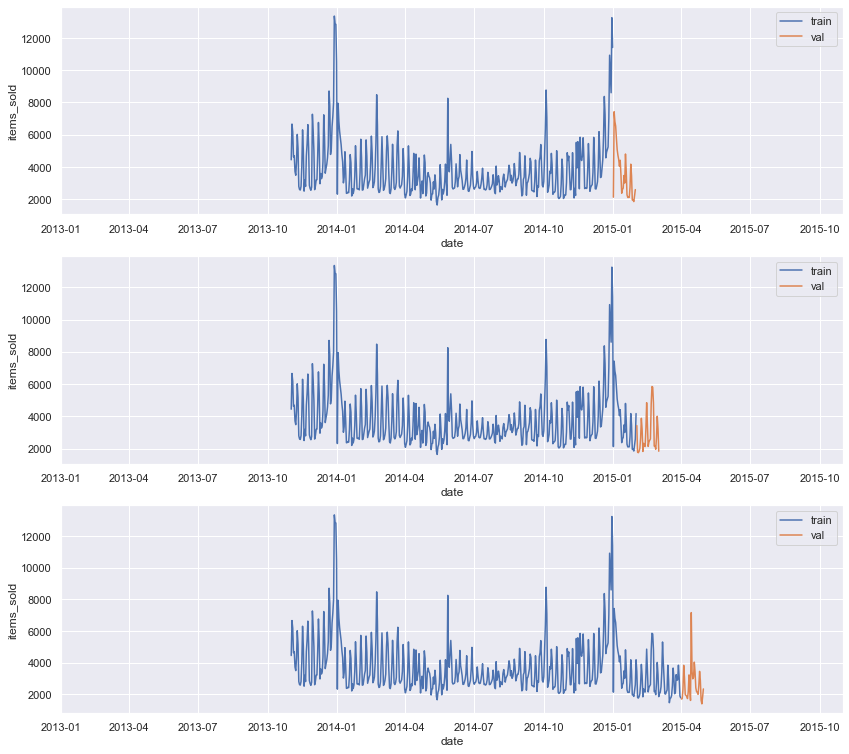

In [13]:
sns.set(rc={'figure.figsize':(14,13)})
fig, axes = plt.subplots(ncols=1, nrows=3)
i = 1
for ax in axes:
    train_data, val_data = vc.split_data(sales, train_start=date(2013,11,1), 
                                                val_start=date(2015,i,1))
    sns.lineplot(data=get_dynamics(train_data), x='date', y='items_sold', ax=ax, label='train')
    sns.lineplot(data=get_dynamics(val_data), x='date', y='items_sold', ax=ax, label='val')
    ax.set_xlim((sales['date'].min(), sales['date'].max()));
    ax.legend()
    i *= 2

### Saving a few differently split datasets for future use

In [14]:
train_data, val_data = vc.split_data(sales, train_start=date(2013,11,1), val_start=date(2015,1,1))
train_data.to_csv('../data/interim/train_2013-11_to_2014-12.csv', index=False, date_format='%Y-%m-%d')
val_data.to_csv('../data/interim/val_2015-1.csv', index=False, date_format='%Y-%m-%d')

train_data, val_data = vc.split_data(sales, train_start=date(2013,1,1), val_start=date(2015,5,1))
train_data.to_csv('../data/interim/train_2013-1_to_2015-4.csv', index=False, date_format='%Y-%m-%d')
val_data.to_csv('../data/interim/val_2015-5.csv', index=False, date_format='%Y-%m-%d')

train_data, val_data = vc.split_data(sales, train_start=date(2013,6,1), val_start=date(2015,7,1))
train_data.to_csv('../data/interim/train_2013-6_to_2015-6.csv', index=False, date_format='%Y-%m-%d')
val_data.to_csv('../data/interim/val_2015-7.csv', index=False, date_format='%Y-%m-%d')

train_data, val_data = vc.split_data(sales, train_start=date(2013,3,1), val_start=date(2015,8,1))
train_data.to_csv('../data/interim/train_2013-3_to_2015-7.csv', index=False, date_format='%Y-%m-%d')
val_data.to_csv('../data/interim/val_2015-8.csv', index=False, date_format='%Y-%m-%d')

# Feature extraction

In [15]:
import re
from sklearn.preprocessing import LabelEncoder

In [16]:
sample_sub = pd.read_csv('../data/raw/sample_submission.csv')
test = pd.read_csv('../data/interim/test_etl.csv')
print(sample_sub.head(3))
print(test.head(3))

   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
   Unnamed: 0  ID  shop_id  item_id
0           0   0        5     5037
1           1   1        5     5320
2           2   2        5     5233


We are supposed to predict amount of items sold next month having `item_id` and `shop_id`. **and** looking at test data, we see that our validation set needs to contain sales for **one and only the next month**.

Therefore, we need to extract useful features from what we have, avoiding data leakage.

### Preparing some additional features

In [17]:
shops = pd.read_csv('../data/interim/shops_etl.csv')
items = pd.read_csv('../data/interim/items_etl.csv')
item_cat = pd.read_csv('../data/interim/item_categories_etl.csv')

In [18]:
shops['city'] = shops['shop_name'].apply(lambda s: re.split(' (ТРЦ|ТЦ|ТК|ТРК|МТРЦ|\(|\"|ул)', s)[0])
shops['city'].replace({'Якутск Орджоникидзе, 56': 'Якутск', 'Москва Магазин С21': 'Москва'}, inplace=True)
le = LabelEncoder().fit(shops['city'])
shops['city_id'] = le.transform(shops['city'])
shop_appearence = sales.groupby('shop_id').agg({'date':'min'}).reset_index().rename(columns={'date':'shop_appearence'})
shops = shops.merge(shop_appearence, on='shop_id', how='left')

shops.to_csv('../data/interim/shops_appearence.csv', index=False, date_format='%Y-%m-%d')

In [19]:
item_appearence = sales.groupby('item_id').agg({'date':'min'}).reset_index().rename(columns={'date':'item_appearence'})
items = items.merge(item_appearence, on='item_id', how='left')

items.to_csv('../data/interim/items_appearence.csv', index=False, date_format='%Y-%m-%d')

In [20]:
item_cat['global_cat'] = item_cat['item_category_name'].apply(lambda s: re.split(' (-|\()', s)[0])
le = LabelEncoder().fit(item_cat['global_cat'])
item_cat['global_cat_id'] = le.transform(item_cat['global_cat'])  
item_cat.head()

item_cat.to_csv('../data/interim/item_categories_global.csv', index=False)

In [23]:
sales_month = sales.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_cnt_day':'sum'}).reset_index().rename({'item_cnt_day':'item_cnt_month'}, axis=1)
sales_pivot = pd.pivot_table(sales_month, values='item_cnt_month', index=['item_id', 'shop_id'],columns=['date_block_num']).fillna(0).reset_index()

datasets = {'sales': sales, 'shops': shops, 'items': items, 'item_categories': item_cat, 'sales_lags': sales_pivot}

sales_pivot.to_csv('../data/interim/sales_pivot.csv', index=False)

In [24]:
def build_features(df, lookup_tables, sales_lags):
    
    data = df.copy()
    
    data = data.merge(lookup_tables['shops'], on='shop_id')
№    print('Merging stage complete 1/3')
    data['shop_age_month'] = (data['date'] - data['shop_appearence']).dt.days / 30
    data = data.merge(lookup_tables['items'], on='item_id')
#    print('Merging stage complete 2/3')
    data['item_age_month'] = (data['date'] - data['item_appearence']).dt.days / 30
    
#    print('Merging stage complete 3/3')
    data = data.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_cnt_day':'sum',
                                                                      'shop_age_month' : 'max',
                                                                      'item_age_month' : 'max',
                                                                      'item_category_id' : pd.Series.mode}).reset_index().rename({'item_cnt_day':'item_cnt_month'}, axis=1)
    
    for lag in [1,3,6, 12]:
        data[f'month_lag_{lag}'] = 0
    
    data = data.merge(sales_lags, on=['shop_id', 'item_id'])
    
    
    for i,lag in enumerate([1,3,6, 12]):
        for date_block in data['date_block_num'].unique():
            if date_block - lag >= 0:
                data.loc[data['date_block_num'] == date_block, f'month_lag_{lag}'] = data.loc[data['date_block_num'] == date_block][date_block-lag]
#        print(f'Lag calculating stage complete {i+1}/4')        
    
    data['month'] = data['date_block_num'] % 12 + 1
    data['month_sin'] = np.sin(2 * np.pi * data['month']/12.0)
    data['month_cos'] = np.cos(2 * np.pi * data['month']/12.0)
#    print(f'Month encoding complete')
    data = data.merge(lookup_tables['item_categories'], on='item_category_id')
    data.drop(['date_block_num', 'item_category_name','global_cat','month'], axis=1, inplace=True) 
    data.drop([i for i in range(0, 34)], axis=1, inplace=True) 
    return data

In [20]:
train_x.head()

,item_id,shop_id,shop_age_month,item_age_month,item_category_id,month_lag_1,month_lag_3,month_lag_6,month_lag_12,month_sin,month_cos,global_cat_id
0,27,21,11.066667,11.066667,19,0.0,0.0,0.0,0.0,-0.5,8.660254e-01,5
1,27,26,10.766667,10.766667,19,0.0,0.0,0.0,0.0,-0.5,8.660254e-01,5
2,27,26,14.666667,14.666667,19,0.0,0.0,0.0,0.0,1.0,6.123234e-17,5
3,1372,24,10.166667,10.166667,19,2.0,0.0,0.0,0.0,-0.5,8.660254e-01,5
4,1407,2,10.633333,9.266667,19,1.0,0.0,0.0,0.0,-0.5,8.660254e-01,5


# Modeling

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

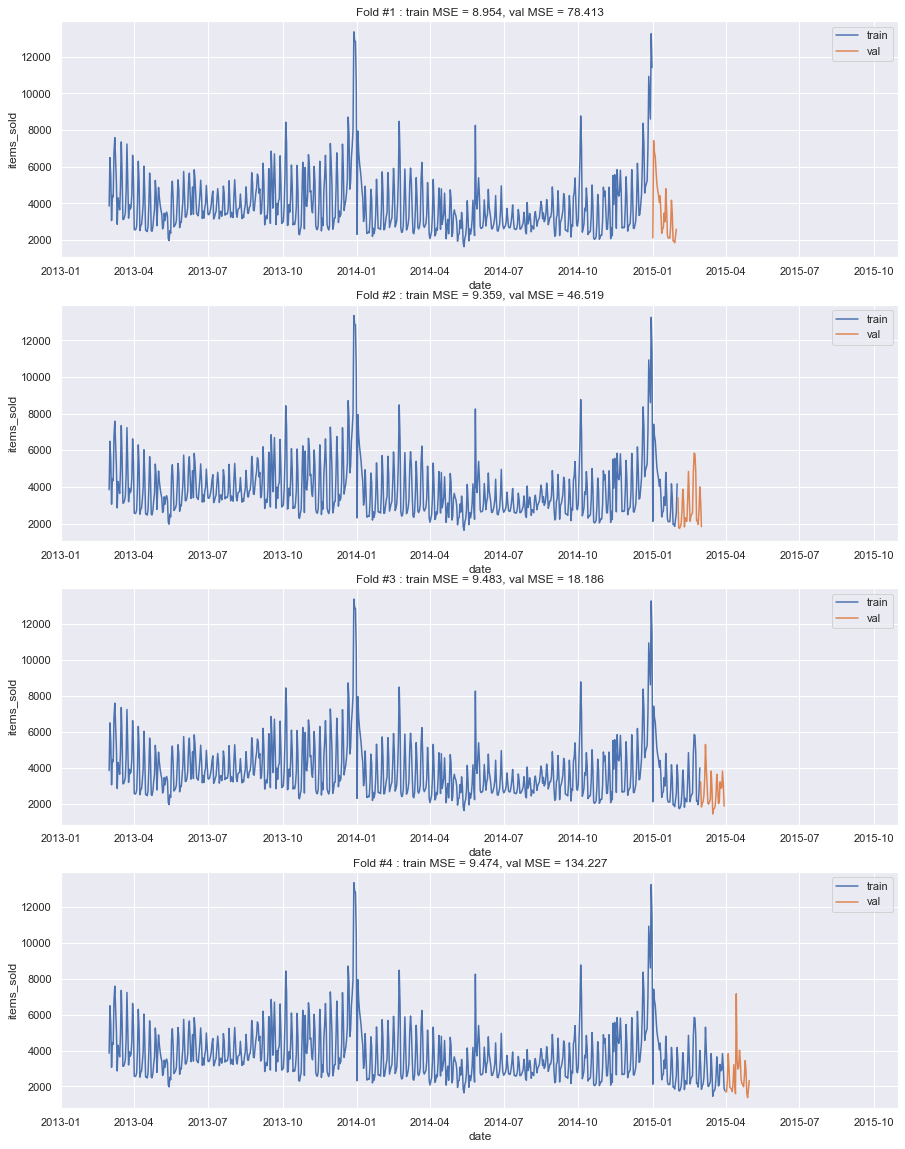

In [33]:
sns.set(rc={'figure.figsize':(15,20)})
fig, axes = plt.subplots(ncols=1, nrows=4)
rfr = RandomForestRegressor(max_depth=15, random_state=1001, n_jobs=-1)
results = []

for month, ax in zip(range(1,5), axes):
    train_data, val_data = vc.split_data(sales, train_start=date(2013,3,1), val_start=date(2015,month,1))
    
    val = build_features(val_data, datasets)
    train = build_features(train_data, datasets)
    
    val_x = val.drop(['item_cnt_month'], axis=1)
    val_y = val['item_cnt_month']
    train_x = train.drop(['item_cnt_month'], axis=1)
    train_y = train['item_cnt_month']

    rfr.fit(X=train_x, y=train_y)
    
    train_mse = mean_squared_error(train_y, rfr.predict(train_x))
    y_pred = rfr.predict(val_x)
    val_mse = mean_squared_error(val_y, y_pred)
    
    sns.lineplot(data=get_dynamics(train_data), x='date', y='items_sold', ax=ax, label='train')
    sns.lineplot(data=get_dynamics(val_data), x='date', y='items_sold', ax=ax, label='val')
    
    ax.set_xlim((sales['date'].min(), sales['date'].max()));
    ax.legend()
    ax.set_title(f'Fold #{month} : train MSE = {round(train_mse, 3)}, val MSE = {round(val_mse,3)}')
    
    results.append({'val_x': val_x, 'val_y': val_y, 'y_pred': y_pred})

## Some error investigation

In [63]:
for res in results:
    val = res['val_x'].copy()
    val['error'] = (res['val_y'] - res['y_pred'])**2 / val.shape[0]
    biggest_errors = val.loc[val['error'].sort_values(ascending=False).index][:100]
    res['biggest_errors'] = biggest_errors

In [85]:
def investigate_errors(res, col):
    sns.set(rc={'figure.figsize':(16,10)})
    fig, axes = plt.subplots(ncols=2, nrows=2)
    for i, ax in enumerate(axes.flatten()):
        ax.set_title(f'Fold {i+1}')
        sns.countplot(data=res[i]['biggest_errors'], y=col, ax=ax, order = res[i]['biggest_errors'][col].value_counts().iloc[:15].index)
    plt.suptitle(f'{col} investigation');

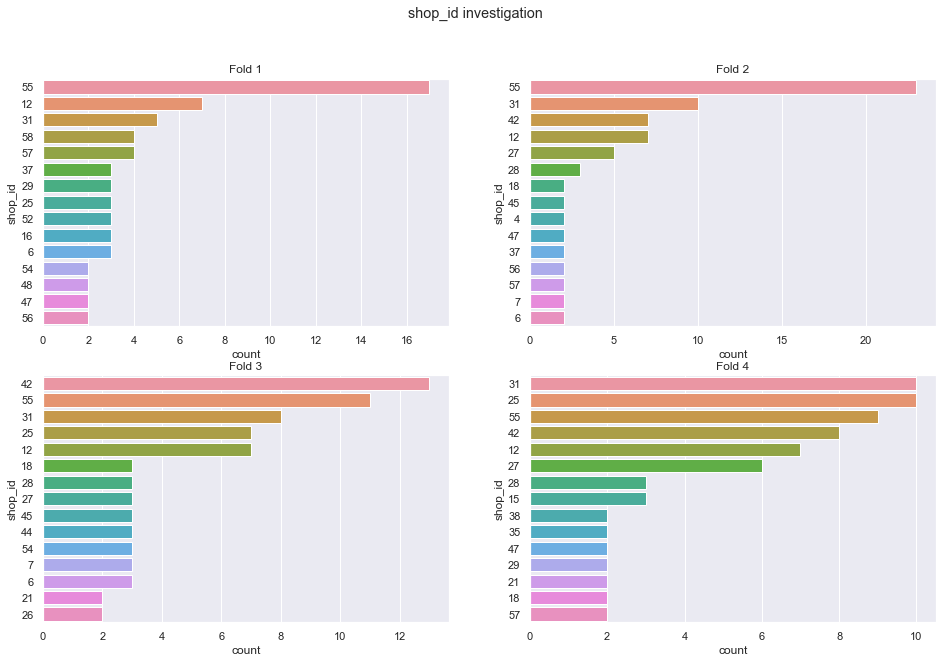

In [86]:
investigate_errors(results, 'shop_id')

Problematic shops - *55*, *31*, *12*, *25*, *42*

In [29]:
print(f'Model tends to make bigger error if sample is from a {shops.loc[55].shop_name} shop')
print('Most error-prone global categories are:')
print(item_cat[item_cat['global_cat_id'].isin([8,13])]['global_cat'].unique())
print('Especially:')
print(item_cat[item_cat['item_category_id'].isin([71,28])]['item_category_name'].unique())
print('Most error-prone items:')
print(items[items['item_id'].isin([6396,20949])]['item_name'].unique())

Model tends to make bigger error if sample is from a Цифровой склад 1С-Онлайн shop
Most error-prone global categories are:
['Игры PC' 'Подарки']
Especially:
['Игры PC - Дополнительные издания'
 'Подарки - Сумки, Альбомы, Коврики д/мыши']
Most error-prone items:
['Saints Row. Gat out of Hell. Издание первого дня [PC, русские субтитры]'
 'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм']


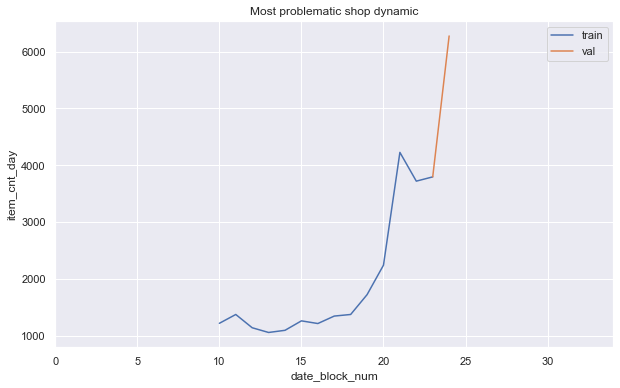

In [30]:
sns.set(rc={'figure.figsize':(10,6)})
shop_dynamic = train_data[train_data['shop_id'] == 55].groupby(['date_block_num']).agg({'item_cnt_day':'sum'}).reset_index()
sns.lineplot(data=shop_dynamic, x='date_block_num', y='item_cnt_day', label='train')
shop_dynamic_val = val_data[val_data['shop_id'] == 55].groupby(['date_block_num'], as_index=False).agg({'item_cnt_day':'sum'}).append(shop_dynamic.iloc[-1]).reset_index()
sns.lineplot(data=shop_dynamic_val, x='date_block_num', y='item_cnt_day', label='val')
plt.xlim([0,34]);
plt.title('Most problematic shop dynamic');

We can see that data we got in validation is **vastly** different from one we got in training.

Also our validation data happens to be *January*, which id clode to december and sales around these months are kind of unstable. Perhaps we could extend our training set to include this period.

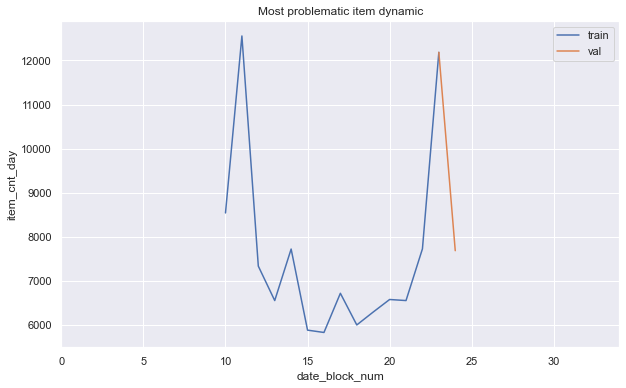

In [31]:
sns.set(rc={'figure.figsize':(10,6)})
shop_dynamic = train_data[train_data['item_id']==20949].groupby(['date_block_num']).agg({'item_cnt_day':'sum'}).reset_index()
sns.lineplot(data=shop_dynamic, x='date_block_num', y='item_cnt_day', label='train')
shop_dynamic_val = val_data[val_data['item_id']==20949].groupby(['date_block_num']).agg({'item_cnt_day':'sum'}).reset_index().append(shop_dynamic.iloc[-1])
sns.lineplot(data=shop_dynamic_val, x='date_block_num', y='item_cnt_day', label='val')
plt.xlim([0,34]);
plt.title('Most problematic item dynamic');